In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CondNet')

In [ ]:
from tqdm.notebook import tqdm

import importlib
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, Size
from torch import autograd
from torch.nn import Module
from typing import Optional
from torch.nn import functional as F

import fcn
import fcn8
import img_utils as iu
import loss_iter
import CondNet

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
importlib.reload(iu)
np.random.seed(0)
iu.gen_images(10000, 32, 32)

In [ ]:
class ReductionBlock(nn.Module):

    def __init__(self, in_channels):
        super(ReductionBlock, self).__init__()
        self.in_channels = in_channels
        self.net = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=(4, 4)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(32, 48, kernel_size=(4, 4)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(48, 64, kernel_size=(4, 4)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(64, 96, kernel_size=(4, 4)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Upsample(scale_factor=64)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class ReductionBlock32(nn.Module):

    def __init__(self, in_channels):
        super(ReductionBlock32, self).__init__()
        self.in_channels = in_channels
        self.net = nn.Sequential(
            nn.Conv2d(self.in_channels, 48, kernel_size=(4, 4)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(48, 64, kernel_size=(4, 4)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(64, 96, kernel_size=(4, 4)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Upsample(scale_factor=32)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class MainBlock(nn.Module):
    
    def __init__(self, in_channels, kernel_size):
        super(MainBlock, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.reduction_block = ReductionBlock32(self.in_channels)
        self.batch_norm = nn.BatchNorm2d(self.in_channels)
        
        if self.kernel_size % 2 == 0:
            self.zero_pad = nn.ZeroPad2d(padding=(3, 0, 3, 0))
            self.conv_layer = nn.Conv2d(self.in_channels + 96, 64, kernel_size=self.kernel_size, padding=0)
        else:
            self.conv_layer = nn.Conv2d(self.in_channels + 96, 64, kernel_size=self.kernel_size, padding=self.kernel_size // 2)
    def forward(self, x):
        x = self.batch_norm(x)
        reduced_x = self.reduction_block(x)
        # print(reduced_x.shape, x.shape)
        x = torch.cat((x, reduced_x), dim=1)
        if self.kernel_size % 2 == 0:
            x = self.zero_pad(x)
        x = self.conv_layer(x)
        x_mean = x.mean()
        ones = torch.ones(x.shape)
        if torch.cuda.is_available():
          ones = ones.cuda()
        x = torch.cat((x, x_mean * ones), dim=1)
        return x

In [ ]:
class CondNet(nn.Module):

    def __init__(self, in_channels, n_class=3):
        super(CondNet, self).__init__()
        self.in_channels = in_channels
        self.n_class = n_class
        self.net = nn.Sequential(
            MainBlock(self.in_channels, 3),
            nn.ELU(),
            MainBlock(128, 4),
            nn.ELU(),
            MainBlock(128, 5),
            nn.ELU(),
        )

        self.cond_linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self.cluster_linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 2)
        )
        # self.cluster = nn.Sequential(
        #     nn.Conv2d(128, 64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 32, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 2, kernel_size=1),
        # )

        # self.segmentation = nn.Sequential(
        #     nn.Conv2d(128, 64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 32, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32, self.n_class, kernel_size=1),
        # )

        self.seg_linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 3),
        )

        # self.seg_net = nn.Sequential(
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(128, 64, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(64, 32, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(32, self.n_class, kernel_size=1, padding=0),
        # )

    def forward(self, x):
        x = self.net(x)
        # print(x.shape)
        # clust = self.cluster(x).permute(0, 2, 3, 1)
        # seg = self.segmentation(x)

        x = x.permute(0, 2, 3, 1)
        # print(x.shape, y.shape)
        beta = self.cond_linear(x).squeeze(3)
        clust = self.cluster_linear(x)
        seg = self.seg_linear(x).permute(0, 3, 1, 2)
        return beta, clust, seg

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

test_net = CondNet(3)
test_net.cuda()

opt1 = optim.Adam(test_net.parameters(), lr=10**(-7))
scheduler = optim.lr_scheduler.StepLR(opt1, step_size=100, gamma=0.5)

In [ ]:
importlib.reload(loss_iter)
loss_func = loss_iter.CondLoss(loss_function=nn.CrossEntropyLoss(reduce=False, ignore_index=-1), q_min=0.8, supression=2, cond_weight=20, cuda=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
import gc
try:
  del(dataloader)
except:
  pass
try:
  del(ds)
except:
  pass
try: 
  del(data)
except:
  pass
try:
  del(mask)
except:
  pass
try:
  del(matrix)
except:
  pass
try:
  del(test_matrix)
except:
  pass
try:
  del(test_noise)
except:
  pass
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
ds = iu.ImageDataset('')

In [ ]:
len(ds)

10000

In [ ]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=200, shuffle=False)#, collate_fn=lambda batch: [(dp[0], dp[1], dp[2]) for dp in batch])

In [ ]:
data, mask, matrix = next(iter(dataloader))

test_net.cuda()
test_net.train()

data = data.cuda().float()
output = test_net(data)

In [ ]:
for i in range(len(output)):
  print(output[i].shape)

In [ ]:
from matplotlib.lines import Line2D   

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:


test_net.cuda()
test_net.train()
for i, (data, mask, matrix) in enumerate(dataloader):
  if (i < 9):
    print(f"i is {i}")
    data = data.cuda().float()
    mask = mask.cuda().squeeze(1)
    matrix = matrix.cuda().float()
    with autograd.detect_anomaly():
      opt1.zero_grad()
      beta, test_x, segmentation = test_net(data)
      test_matrix = matrix.reshape(matrix.shape[0], matrix.shape[1], -1)
      test_out = nn.Sigmoid()(beta)
      test_beta = test_out.reshape(test_out.shape[0], -1)
      print(torch.sum(test_beta < -1), torch.sum(test_beta > 1))
      test_q = loss_func.atanh(test_beta) ** 2 + loss_func.q_min
      print(f"q not nan: {torch.sum(torch.isnan(test_q))}")
      print(f"q max: {torch.max(test_q - loss_func.q_min, dim=1)}")
      test_noise = (torch.sum(test_matrix, dim=1) < 1).float()
      print(f"Noise vertices: {torch.sum(test_noise, dim=1)}")
      print(f"test_noise : {torch.sum((1 - test_noise) * (test_q - loss_func.q_min), dim=1)}")
      print(mask.shape, segmentation.shape)
      temp_general_loss = loss_func.general_loss(test_noise, test_q, segmentation, mask)
      temp_background_loss = loss_func.background_loss(test_beta, test_matrix, test_noise, test_matrix.shape[1])
      temp_potential_loss = loss_func.potential_loss(test_x.reshape(10, -1, 2), test_q, test_matrix, 64, 64, test_matrix.shape[1])
      print(f"General loss: {temp_general_loss}")
      print(f"Background loss: {temp_background_loss}")
      print(f"Potential loss: {temp_potential_loss}")
      print(f"Overall loss: {(temp_general_loss + loss_func.cond_weight * (temp_background_loss + temp_potential_loss)).mean()}")
      # print(test_noise.shape)
      # print(test_noise)
      # print(torch.sum(torch.eq(test_noise, 0)), torch.sum(torch.isnan(test_out)), torch.sum(torch.isnan(output[1])))
      if i < 8:
        curr_loss = loss_func(test_x, test_out, matrix, segmentation, mask)
        print(torch.sum(torch.isnan(curr_loss)))
        print(curr_loss.item())
        curr_loss.backward()
        opt1.step()

In [ ]:
plot_grad_flow(test_net.named_parameters())

In [ ]:
import shutil
shutil.make_archive('pics', 'zip', "pics")

'/content/pics.zip'

In [ ]:
n_epochs = 200
# torch.autograd.set_detect_anomaly = True
loss_vs_epoch = []
test_net.cuda().float()
# sigmoid = nn.Sigmoid()
for epoch in tqdm(range(n_epochs)):
    temp_loss = 0
    test_net.train()
    for i, (data, mask, matrix) in enumerate(dataloader):
        opt1.zero_grad()
        data = data.cuda().float()
        mask = mask.cuda().squeeze(1)
        matrix = matrix.cuda().float()
        try:
          with autograd.detect_anomaly():
            output = test_net(data)
            curr_loss = loss_func(output[1], output[0], matrix, output[2], mask)
            curr_loss.backward()
            opt1.step()
        except Exception as e:
          print(i, curr_loss)
          print(e)
          raise
        temp_loss += curr_loss.item() * data.size(0)
    loss_vs_epoch.append(temp_loss / len(dataloader.sampler))
    print(f"Epoch: {epoch}, Loss: {loss_vs_epoch[-1]}")
    torch.save(test_net.state_dict(), 'net_my_fcn.pt')
    scheduler.step()
    # plot_epoch(epoch, 0.05, 0.5)

torch.save(test_net.state_dict(), '/content/drive/My Drive/Colab Notebooks/CondNet/net_my_fcn.pt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  from ipykernel import kernelapp as app


Epoch: 0, Loss: 33.72305763244629
Epoch: 1, Loss: 33.699264793396
Epoch: 2, Loss: 33.67530055999756
Epoch: 3, Loss: 33.65188629150391
Epoch: 4, Loss: 33.62871509552002
Epoch: 5, Loss: 33.605427742004395
Epoch: 6, Loss: 33.582970695495604
Epoch: 7, Loss: 33.55979740142822
Epoch: 8, Loss: 33.537030448913576
Epoch: 9, Loss: 33.514293060302734
Epoch: 10, Loss: 33.492165412902835
Epoch: 11, Loss: 33.470236167907714
Epoch: 12, Loss: 33.44874053955078
Epoch: 13, Loss: 33.42694976806641
Epoch: 14, Loss: 33.40531551361084
Epoch: 15, Loss: 33.38399394989014
Epoch: 16, Loss: 33.36316997528076
Epoch: 17, Loss: 33.34234909057617
Epoch: 18, Loss: 33.32122859954834
Epoch: 19, Loss: 33.300675506591794
Epoch: 20, Loss: 33.28075695037842
Epoch: 21, Loss: 33.260907592773435
Epoch: 22, Loss: 33.24089817047119
Epoch: 23, Loss: 33.22182613372803
Epoch: 24, Loss: 33.202173500061036
Epoch: 25, Loss: 33.18379364013672
Epoch: 26, Loss: 33.165113334655764
Epoch: 27, Loss: 33.1465930557251
Epoch: 28, Loss: 33.128

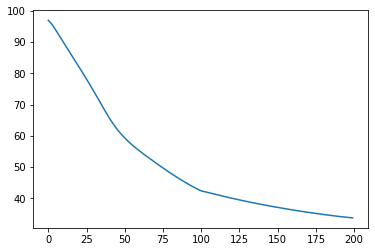

In [ ]:
plt.plot(loss_vs_epoch)

In [ ]:
test_matrix = matrix.reshape(matrix.shape[0], matrix.shape[1], -1)
test_out = nn.Sigmoid()(output[0])
test_beta = test_out.reshape(test_out.shape[0], -1)
print(torch.sum(test_beta < -1), torch.sum(test_beta > 1))
test_q = loss_func.atanh(test_beta) ** 2 + loss_func.q_min
print(f"q not nan: {torch.sum(torch.isnan(test_q))}")
print(f"q max: {torch.max(test_q - loss_func.q_min, dim=1)}")
test_noise = (torch.sum(test_matrix, dim=1) < 1).float()
print(f"Noise vertices: {torch.sum(test_noise, dim=1)}")
print(f"test_noise : {torch.sum((1 - test_noise) * (test_q - loss_func.q_min), dim=1)}")

In [ ]:
test_loss = loss_func.loss_function(output[2], mask)
test_loss = test_loss.reshape(test_loss.shape[0], -1)
print(torch.sum((1 - test_noise) * (test_q - loss_func.q_min) * test_loss, dim=1))

In [ ]:
test_net.cuda()
test_net.train()
for i in range(100):
  print(f"i is {i}")
  data, mask, matrix = ds[i + 6400]
  data = data.unsqueeze(0).cuda().float()
  mask = mask.unsqueeze(0).cuda().float()
  matrix = matrix.unsqueeze(0).cuda().float()
  with autograd.detect_anomaly():
    test_out = nn.Sigmoid()(output[:, 0, :, :])
    output = test_net(data)
    curr_loss = loss_func(test_out, matrix, output[:, 1:4, :, :], mask)
    if (torch.sum(torch.isnan(curr_loss)) > 0):
      print(i)
      test_matrix = matrix.reshape(matrix.shape[0], matrix.shape[1], -1)
      
      test_beta = test_out.reshape(test_out.shape[0], -1)
      print(torch.sum(test_beta < -1), torch.sum(test_beta > 1))
      test_q = loss_func.atanh(test_beta) ** 2 + loss_func.q_min
      print(f"q not nan: {torch.sum(torch.isnan(test_q))}")
      print(f"q max: {torch.max(test_q - loss_func.q_min, dim=1)}")
      test_noise = (torch.sum(test_matrix, dim=1) < 1).float()
      print(f"Noise vertices: {torch.sum(test_noise, dim=1)}")
      print(f"test_noise : {torch.sum((1 - test_noise) * (test_q - loss_func.q_min), dim=1)}")
      temp_general_loss = loss_func.general_loss(test_noise, test_q, output[:, 1:4, :, :], mask)
      temp_background_loss = loss_func.background_loss(test_beta, test_matrix, test_noise, test_matrix.shape[1])
      temp_potential_loss = loss_func.potential_loss(test_q, test_matrix, 64, 64, test_matrix.shape[1])
      print(f"General loss: {temp_general_loss}")
      print(f"Background loss: {temp_background_loss}")
      print(f"Potential loss: {temp_potential_loss}")
      print(f"Overall loss: {(temp_general_loss + loss_func.cond_weight * (temp_background_loss + temp_potential_loss)).mean()}")
      break
      print(curr_loss.item())

In [ ]:
dl = iter(dataloader)
data, mask, _ = next(dl)
data = data.cuda().float()
mask = mask.cuda().float()
test_net.eval()
# data = data.cuda().float()
# mask = mask.cuda().float()
test_out = test_net(data)

In [ ]:
test_net.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/CondNet/net_my_fcn.pt'))

<All keys matched successfully>

In [ ]:
from torchvision.transforms import ToPILImage

def plot_epoch(epoch, tbeta, td):
    arr = [i for i in np.random.randint(0, 10000, 16)]
    for i in arr:
        data, _, matrix = ds[i]

        data = data.unsqueeze(0).cuda().float()
        test_net.eval()
        beta, x, mask = test_net(data)
        
        # beta = nn.Sigmoid()(beta)

        temp_x, colors = find_condensation(beta, x, matrix, tbeta, td)
        matrix = ToPILImage()(matrix)
        mask = ToPILImage()(mask[0, 0, :, :].cpu())
        # x = x.reshape(1, -1, 2)
        # x = x[0, test_beta > 0.3, :]
        fig, ax = plt.subplots(2, 2, figsize=(8,8))


        ax[0, 0].imshow(beta[0, :, :].cpu().data.numpy())
        ax[0, 1].imshow(mask)

        ax[1, 0].scatter(*zip(*temp_x), c=colors)
        ax[1, 1].imshow(matrix)
        fig.suptitle(f'Epoch: {epoch}', fontsize=10)
        fig.tight_layout()

        plt.savefig(f"pics/{i}_{epoch}.png")
        plt.close()

In [ ]:
!pip install image-grid
!mkdir pics

mkdir: cannot create directory ‘pics’: File exists


In [ ]:
!rm pics/*
plot_epoch(39, 0.01, 0.2)
!image-grid -f pics -r 4 -c 4 -q 100 -y

saved image-grid.jpg, (2310, 2310, 3), 1.4MiB


tensor(48.9548, device='cuda:0', grad_fn=<MaxBackward1>) tensor(22.8832, device='cuda:0', grad_fn=<MinBackward1>)


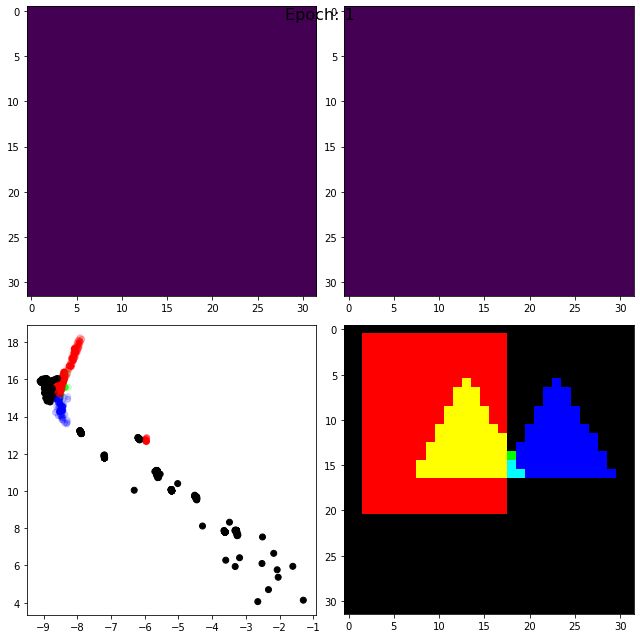

In [ ]:
data, mask, matrix = ds[256]

data = data.unsqueeze(0).cuda().float()
test_net.eval()
beta, x = test_net(data)
beta = nn.Sigmoid()(beta)

temp_x, colors = find_condensation(beta, x, matrix, 0.1, 0.2)
matrix = ToPILImage()(matrix)
fig, ax = plt.subplots(2, 2, figsize=(9,9))


ax[0, 0].imshow(beta[0, :, :].cpu().data.numpy())
ax[0, 1].imshow((beta[0, :, :] > 0.1).cpu().data.numpy())
ax[1, 0].scatter(*zip(*temp_x), c=colors)

# ax[1, 1].imshow((x[0, :, 1]).cpu().data.numpy())
ax[1, 1].imshow(matrix)
fig.suptitle(f'Epoch: {1}', fontsize=16)
fig.tight_layout()
plt.show()

In [ ]:
torch.min(beta)

tensor(1., device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
print(np.max(a), np.min(a), np.max(b), np.min(b))

-13.15254 -19.973686 6.405866 0.9419683


In [ ]:
value, index = torch.sort(test_beta, descending=True)

In [ ]:
def find_condensation(beta, x, matrix, tbeta, td):
    x = x.reshape(x.shape[0], -1, 2).cpu()
    beta = beta.reshape(beta.shape[0], -1).cpu()
    matrix = matrix.reshape(matrix.shape[0], -1).cpu()
    value, index = torch.sort(beta, descending=True)
    # mask = value > tbeta
    num = 256
    index = index[0, :num].cpu()
    x = x[0, index, :]
    cond_points = []
    colors = []
    for i in range(num):
    # while x.shape[0]:
        cond_points.append(x[i].data.numpy())
        if matrix[0, index[i]]:
            colors.append((1, 0, 0, 1 - i / num))
        elif matrix[1, index[i]]:
            colors.append((0, 1, 0, 1 - i / num))
        elif matrix[2, index[i]]:
            colors.append((0, 0, 1, 1 - i / num))
        else:
            colors.append('black')
        # mask = torch.norm(x - x[i], dim=1) >= td
        # x = x[mask]
        # index = index[mask]
    return cond_points, colors
        
        


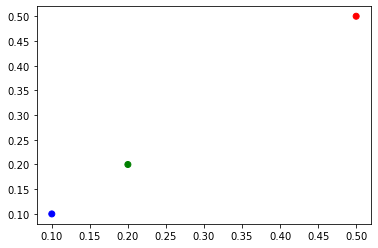

In [ ]:
plt.scatter([0.5, 0.2, 0.1], [0.5, 0.2, 0.1], c=['red', 'green', 'blue'])

torch.Size([64])


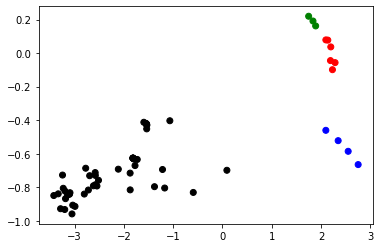

In [ ]:
i = 256
data, _, matrix = ds[i]

data = data.unsqueeze(0).cuda().float()
test_net.eval()
beta, x = test_net(data)

test_beta = nn.Sigmoid()(beta)

lst, colors = find_condensation(test_beta, x, matrix, 0.1, 0.2)
if len(lst) > 0:
    plt.scatter(*zip(*lst), c=colors)